# Goal :
* Data Cleaning and EDA
* Develop a model to predict demand for shared bikes
* Find the Significant Variables for the model with appropriate metrics
* Management can use this to adjust the business strategy to meet the demand levels and meet the customer's expectations.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set()
%matplotlib inline

# Functions

In [3]:
def label_subplots(pp):
  for ax in pp.axes.flat:
      ax.tick_params(axis='both', labelbottom=True)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [4]:
def get_vif(cols):
  df_vif = pd.DataFrame()
  df_vif['Features'] = cols
  df_vif['VIF'] = [VIF(X_train[cols].values, i) for i in range(len(cols))]
  df_vif['VIF'] = round(df_vif['VIF'],2)
  df_vif = df_vif.sort_values(by = "VIF", ascending = False)
  return df_vif

# Data Loading

In [5]:
!git clone "https://github.com/akshaysmin/Bike-Sharing-Demand-Prediction"

Cloning into 'Bike-Sharing-Demand-Prediction'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 31 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [6]:
path = '/content/Bike-Sharing-Demand-Prediction/shared bikes.csv'
df = pd.read_csv(path)

In [7]:
df_bikes = df.copy()

In [8]:
df_bikes.shape

(730, 16)

In [9]:
df_bikes.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [10]:
df_bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Data Cleaning

##Check for missing values

In [11]:
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


* We have no missing values
* All columns are of correct datatype

## Drop Unneccessary Columns

In [12]:
df_bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [13]:
df_bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [14]:
len(df_bikes['instant'].unique())

730

Conclusion : 
* instant represents unique id values for each row and can be dropped
* dteday can be dropped as we have day, year, month, etc. in other columns
* casual and registered can be dropped to avoid data leakage (casual + registered = cnt) as cnt is target variable
* temp and atemp shows very close values and need to be investigated

In [15]:
df_bikes.drop(['instant','dteday', 'casual', 'registered'], axis=1, inplace=True)
df_bikes.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [16]:
df[['temp', 'atemp']].corr()

,temp,atemp
temp,1.000000,0.991696
atemp,0.991696,1.000000


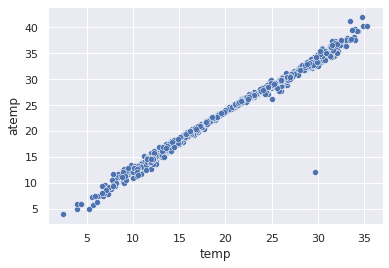

In [17]:
sns.scatterplot(data=df_bikes, x='temp', y='atemp')
plt.show()

* We will select only one of temp or atemp for model. Lets keep both for the time being.

Looking at Correlations

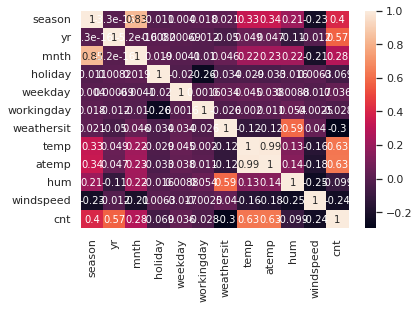

In [18]:
sns.heatmap(df_bikes.corr(), annot=True)
plt.show()

Conclusion:

For all columns except Count(which is target), we have very low correlation

## Renaming columns

In [19]:
df_bikes.rename(columns = {'season':'Season',
                           'yr':'Year',
                           'mnth':'Month',
                           'holiday':'Holiday',
                           'weekday':'Weekday',
                           'workingday':'Workingday',
                           'hum':'Humidity',
                           'windspeed': 'Windspeed',
                           'weathersit':'Weather',
                           'temp' : 'Temperature',
                           'atemp' : 'ATemperature',
                           'cnt':'Count'},
                inplace=True)
df_bikes.columns

Index(['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday',
       'Weather', 'Temperature', 'ATemperature', 'Humidity', 'Windspeed',
       'Count'],
      dtype='object')

##Handling Categorical Variables

Season, Year, Month, Holiday, Weekday, Workingday, Weather

In [20]:
cat_cols = ['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weather']
num_cols = ['Temperature', 'Humidity', 'Windspeed', 'Count']

df_bikes[cat_cols] = df_bikes[cat_cols].astype('category')
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Season        730 non-null    category
 1   Year          730 non-null    category
 2   Month         730 non-null    category
 3   Holiday       730 non-null    category
 4   Weekday       730 non-null    category
 5   Workingday    730 non-null    category
 6   Weather       730 non-null    category
 7   Temperature   730 non-null    float64 
 8   ATemperature  730 non-null    float64 
 9   Humidity      730 non-null    float64 
 10  Windspeed     730 non-null    float64 
 11  Count         730 non-null    int64   
dtypes: category(7), float64(4), int64(1)
memory usage: 35.1 KB


Year

In [21]:
df_bikes['Year'].value_counts()

0    365
1    365
Name: Year, dtype: int64

We will keep yr as it is because the years are not specified

Month

In [22]:
df_bikes['Month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                         ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'),
                         inplace=True
                         )

Season

In [23]:
df_bikes.groupby('Season')['Month'].value_counts()

Season  Month    
1       January      62
        February     56
        March        40
        December     22
2       May          62
        April        60
        June         40
        March        22
3       August       62
        July         62
        September    44
        June         20
4       October      62
        November     60
        December     40
        September    16
Name: Month, dtype: int64

In [24]:
df_bikes['Season'].replace((1,2,3,4),
                           ('Spring', 'Summer', 'Autumn', 'Winter'),
                           inplace=True
                          )

Weather

In [25]:
df_bikes['Weather'].value_counts()

1    463
2    246
3     21
Name: Weather, dtype: int64

In [26]:
df_bikes['Weather'].replace((1,2,3),
                            ('Good/Clear', 'Moderate/Cloudy', 'Bad/Raining'),
                           inplace=True
                           )
df_bikes['Weather'].value_counts()

Good/Clear         463
Moderate/Cloudy    246
Bad/Raining         21
Name: Weather, dtype: int64

Holiday

In [27]:
df_bikes['Holiday'].replace((0,1),
                            ('No', 'Yes'),
                            inplace=True
                            )
df_bikes['Holiday'].value_counts()

No     709
Yes     21
Name: Holiday, dtype: int64

Weekday

In [28]:
df_bikes['Weekday'].value_counts()

1    105
2    105
0    104
3    104
4    104
5    104
6    104
Name: Weekday, dtype: int64

In [29]:
df_bikes['Weekday'].replace((0,1,2,3,4,5,6),
                            ('Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'),
                            inplace=True
                            )
df_bikes['Weekday'].value_counts()

Monday       105
Tuesday      105
Wednesday    104
Thursday     104
Friday       104
Saturday     104
Sunday       104
Name: Weekday, dtype: int64

In [30]:
df_bikes['Workingday'].replace((0,1),
                            ('No','Yes'),
                            inplace=True
                            )
df_bikes['Workingday'].value_counts()

Yes    504
No     226
Name: Workingday, dtype: int64

## Remove Extreme Values

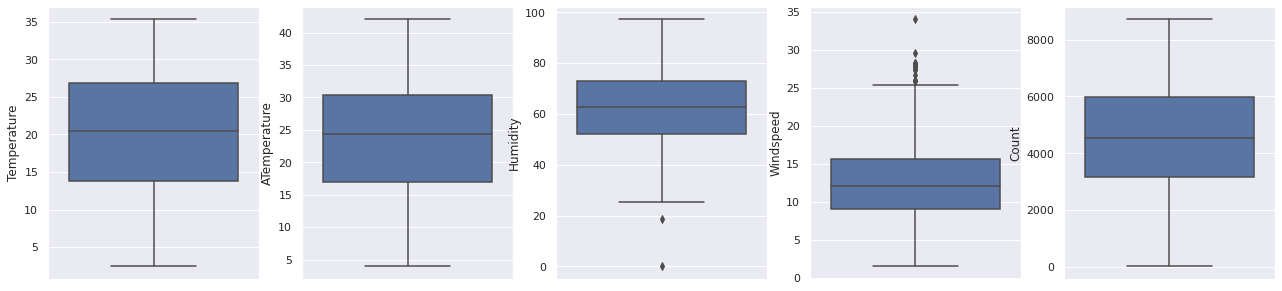

In [32]:
num_cols = ['Temperature', 'ATemperature',  'Humidity', 'Windspeed', 'Count']

fig, axis = plt.subplots(1,5, figsize=(22,5))
for i,col in enumerate(num_cols):
  sns.boxplot(data=df_bikes,
              y=col,
              ax=axis[i])
plt.show()

There doesn't seem to be very extreme values

# Exploratory Data Analysis

In [33]:
df_bikes.head()

,Season,Year,Month,Holiday,Weekday,Workingday,Weather,Temperature,ATemperature,Humidity,Windspeed,Count
0,Spring,0,January,No,Monday,Yes,Moderate/Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,January,No,Tuesday,Yes,Moderate/Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,January,No,Wednesday,Yes,Good/Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,January,No,Thursday,Yes,Good/Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,January,No,Friday,Yes,Good/Clear,9.305237,11.46350,43.6957,12.522300,1600


## Check Relationships using Pairplot

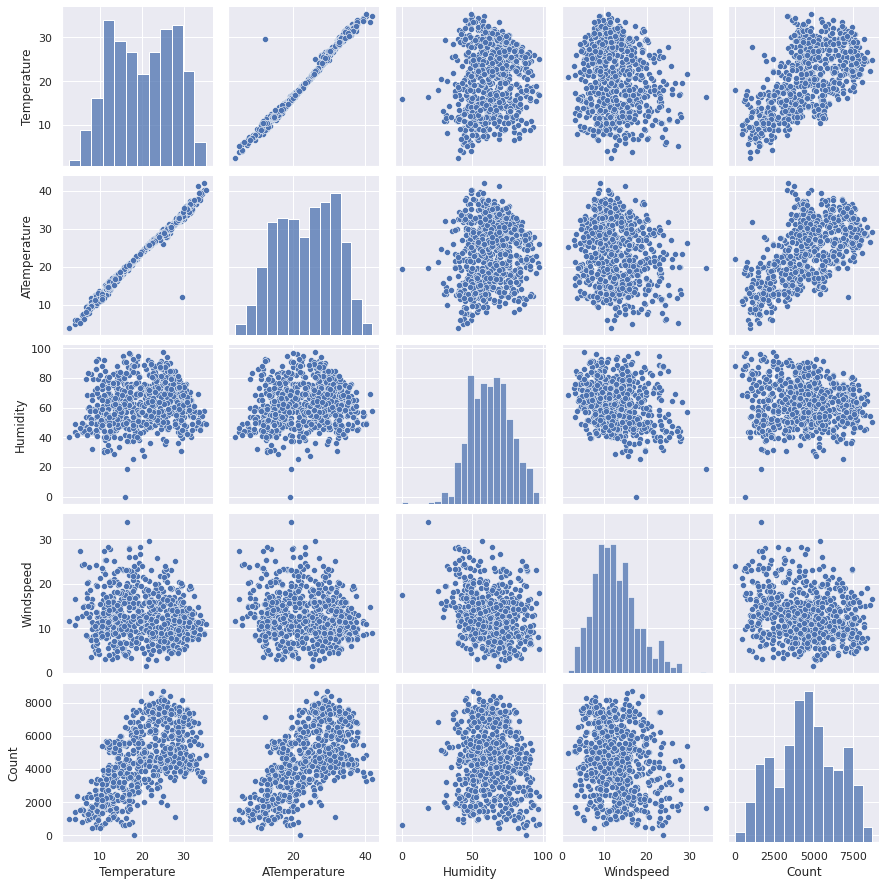

In [34]:
sns.pairplot(df_bikes)
plt.show()

Conclusion:

* Temperature has the highest correlation with Count
* Demand is increasing with year

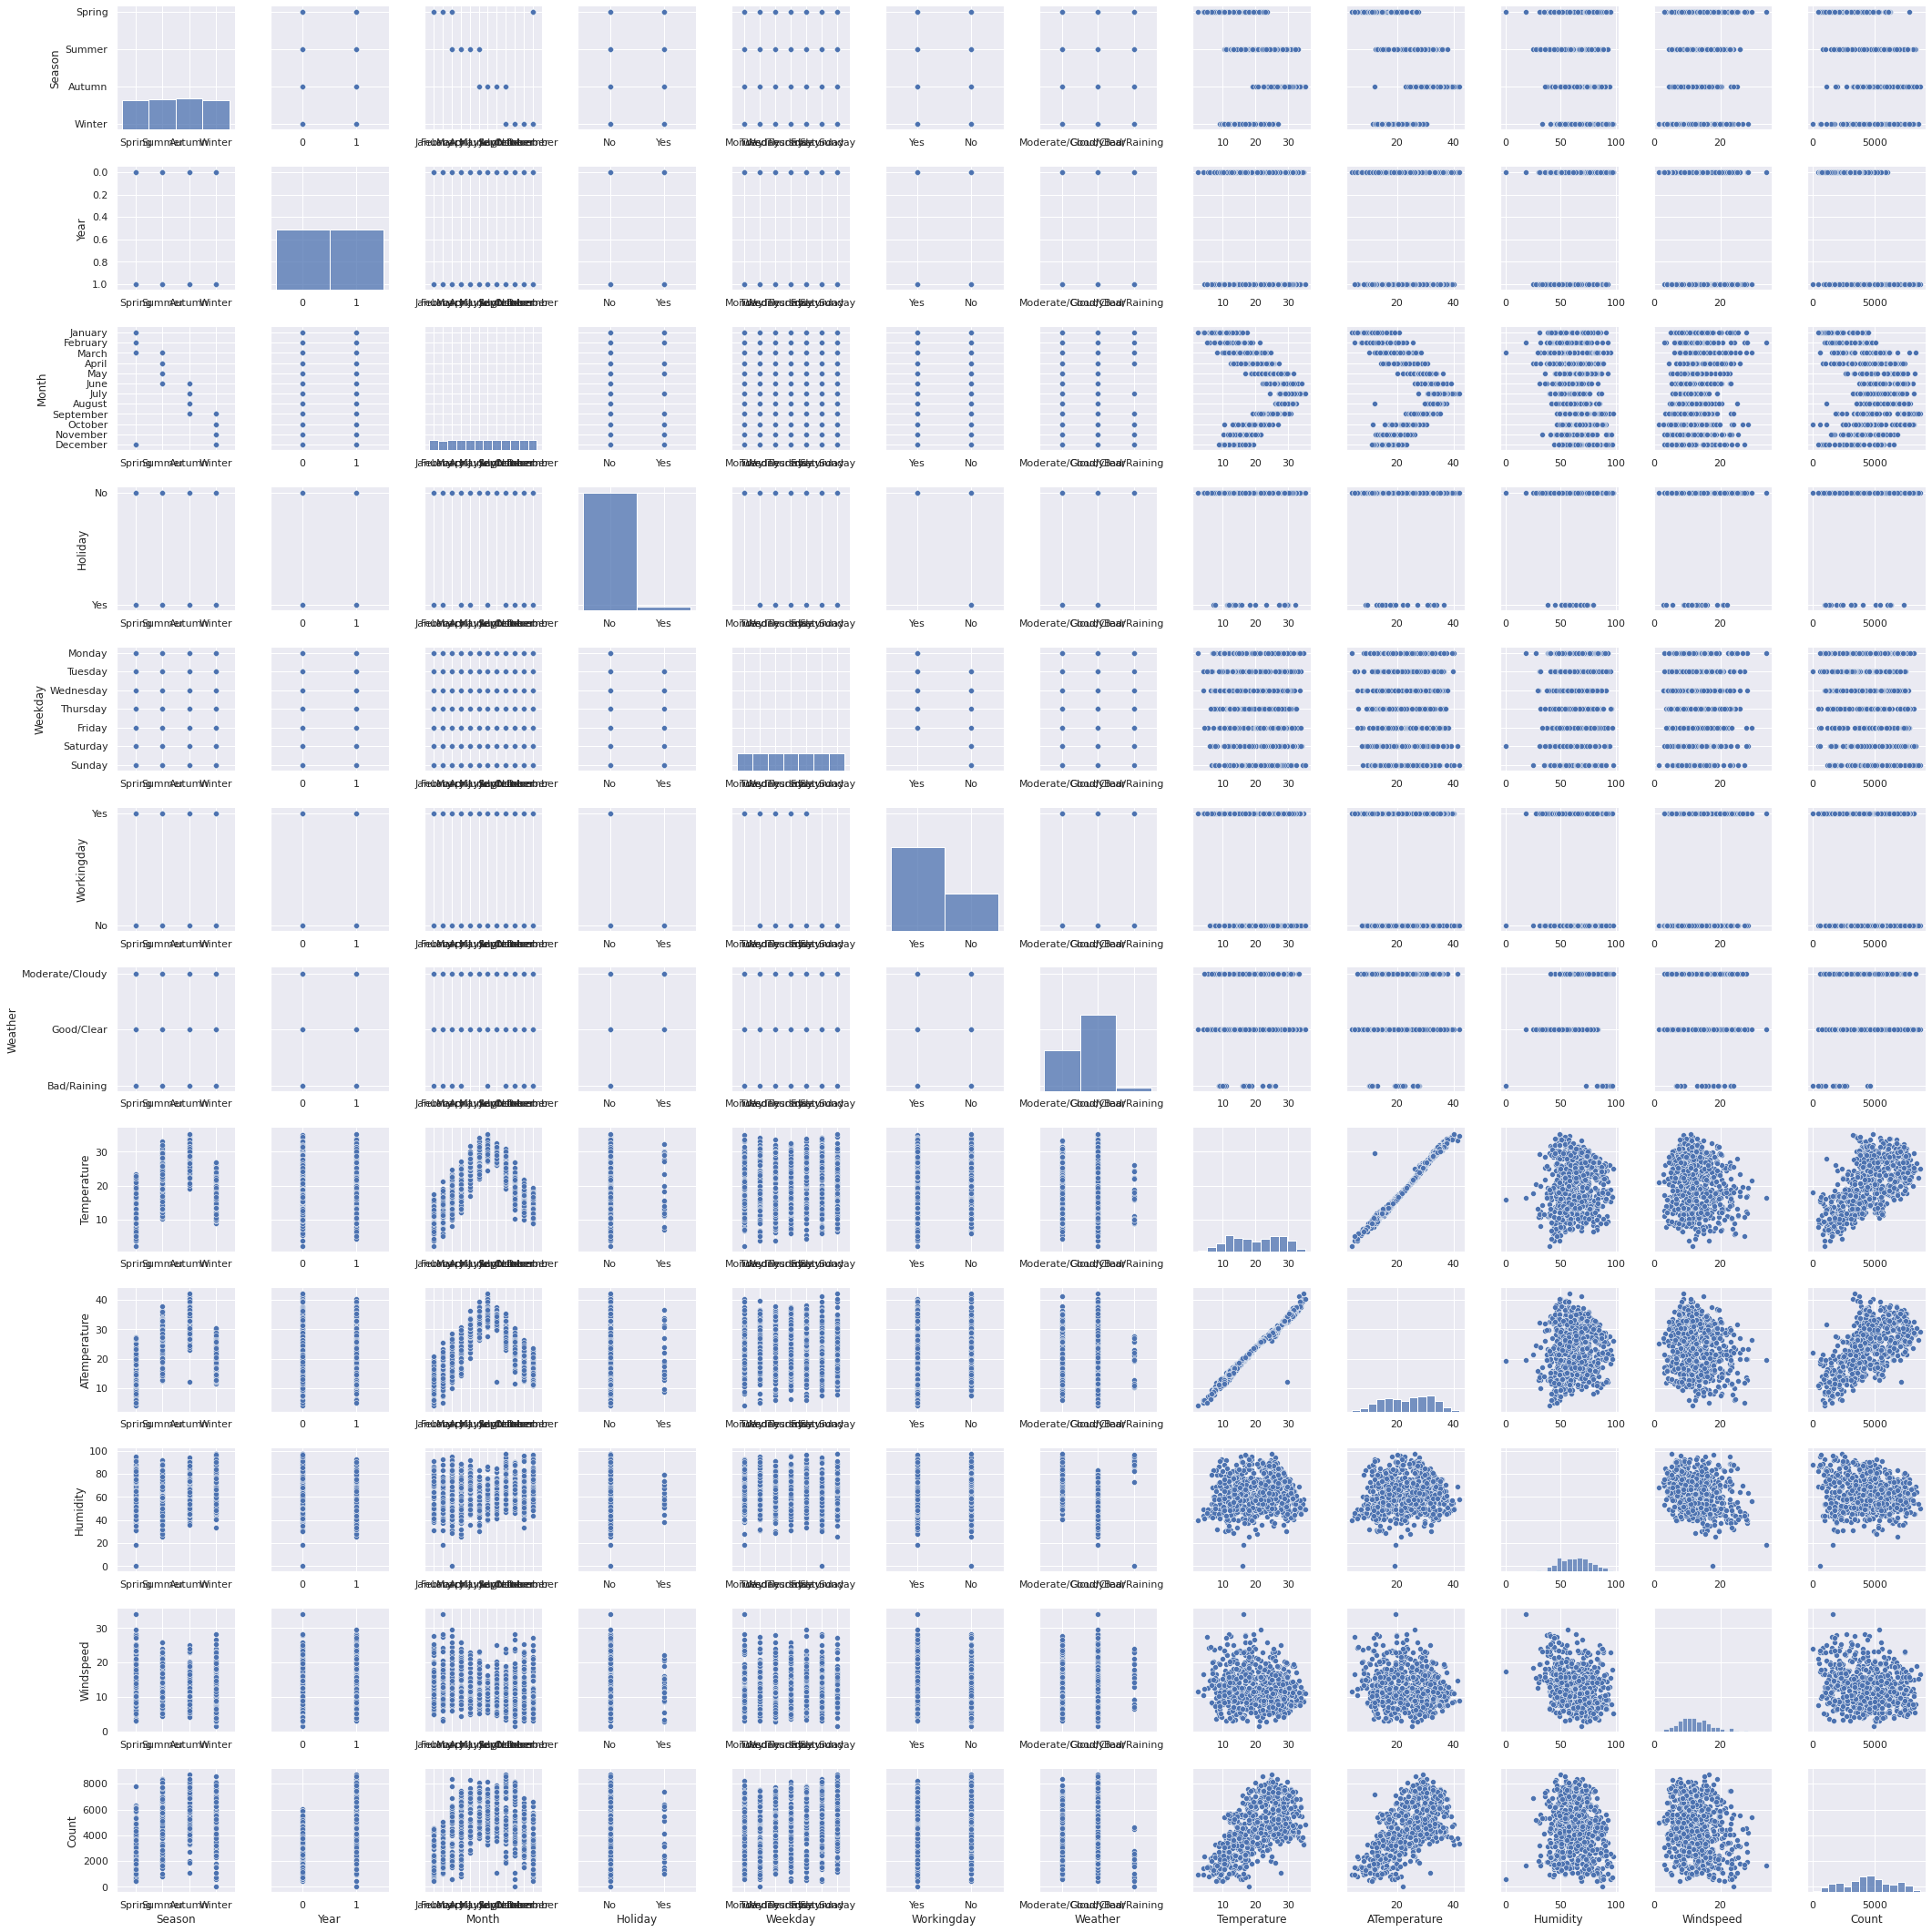

In [35]:
pp = sns.pairplot(df_bikes, 
             vars=df_bikes.columns
             )
label_subplots(pp)

plt.show()

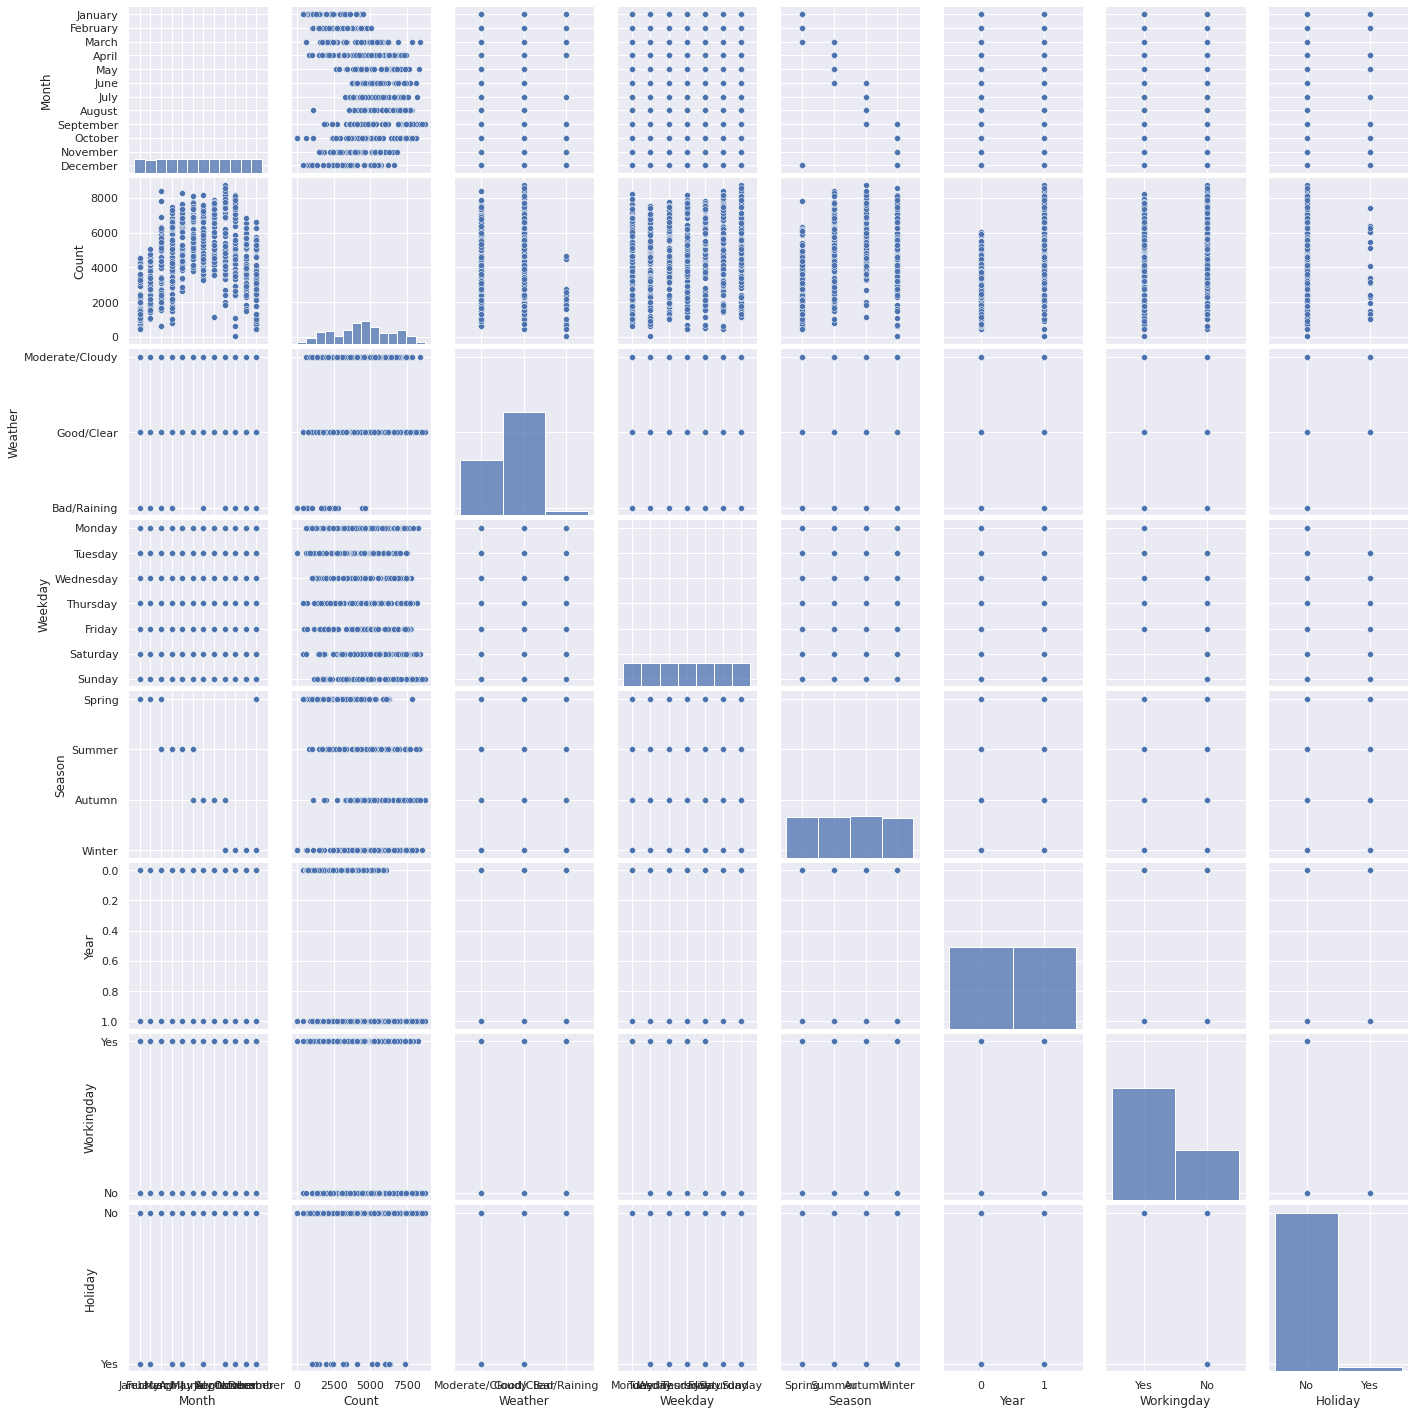

In [36]:
pp = sns.pairplot(df_bikes, 
             vars=(set(df_bikes.columns)-set(num_cols))|{'Count'}
             )
# label_subplots(pp)
plt.show()

Conclusion:
* Most data is around moderate weather, bad weather has very low count
* Demand/Count is low for holiday
* Demand is increasing with year
* Demand and Temperature is parabola shaped with respect to months

## Count vs Categorical Variables

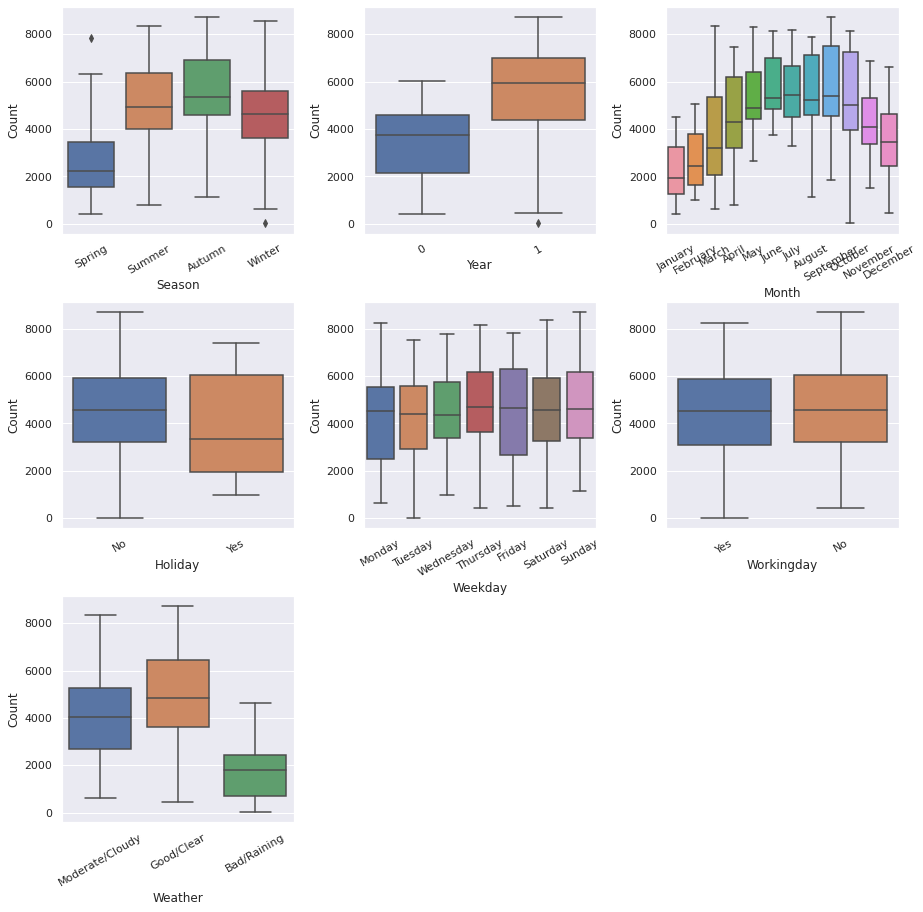

In [37]:
cat_cols = ['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weather']

plt.figure(figsize=(15,15))
for i,col in enumerate(cat_cols):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(data=df_bikes,
                     x=col, 
                     y='Count',
                     order = None if col is not 'Month' else ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
                     )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Conclusions:
* People prefer biking in Clear Weather. Count is least in bad weather
* Spring has the least demand and Autumn has the hihgest
* Count increases with month till June and decreases after October
* Demand is slightly lo on Holiday
* Weekday and Workday doesn't seem to impact Demand in a clear way

## Count vs Numerical Variables

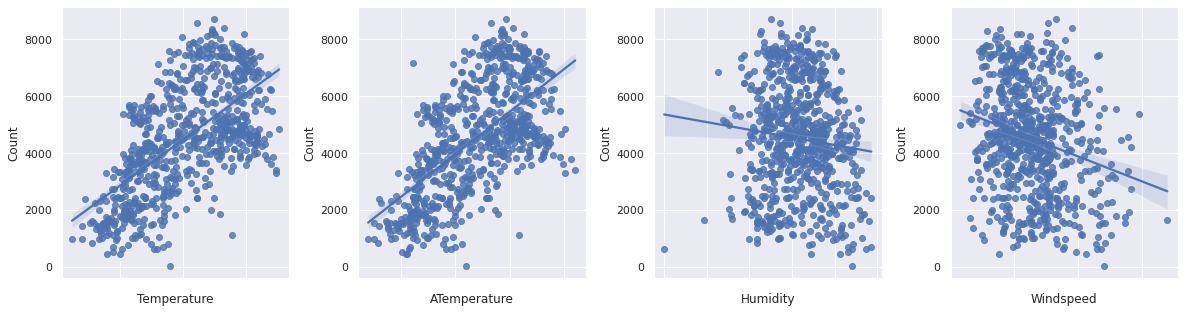

In [51]:
num_cols = ['Temperature', 'ATemperature','Humidity', 'Windspeed']

plt.figure(figsize=(20,5))
for i,col in enumerate(num_cols):
    plt.subplot(1,4,i+1)
    ax = sns.regplot(data=df_bikes,
                     x=col, 
                     y='Count',
                     )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Conclusions:
* Temperature shows most correlation with Count/Demand
* Count is clearly increasing with increase in Temperature
* Humidity and Windspeed have more spread out values
* Humidity and Windspeed shows slightly negative correlation with Demand

# Model

## Data Preperation

In [66]:
cat_cols = ['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weather']
num_cols = ['Temperature', 'ATemperature', 'Humidity', 'Windspeed', 'Count']

dummy = pd.get_dummies(df_bikes[cat_cols])
df_model = pd.concat([df_bikes[num_cols],dummy], axis=1)
df_model.head()

,Temperature,ATemperature,Humidity,Windspeed,Count,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Year_0,...,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Workingday_No,Workingday_Yes,Weather_Bad/Raining,Weather_Good/Clear,Weather_Moderate/Cloudy
0,14.110847,18.18125,80.5833,10.749882,985,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,14.902598,17.68695,69.6087,16.652113,801,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
2,8.050924,9.47025,43.7273,16.636703,1349,0,1,0,0,1,...,0,0,0,0,1,0,1,0,1,0
3,8.200000,10.60610,59.0435,10.739832,1562,0,1,0,0,1,...,0,0,1,0,0,0,1,0,1,0
4,9.305237,11.46350,43.6957,12.522300,1600,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0


Train-Test Split

In [67]:
df_train, df_test = train_test_split(df_model, test_size=0.30, random_state=100)
df_train.shape, df_test.shape, type(df_train), type(df_test)

((511, 37),
 (219, 37),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

Scaling the data

In [68]:
num_cols = ['Temperature', 'ATemperature',  'Humidity', 'Windspeed', 'Count']

scaler = MinMaxScaler()
scaler.fit(df_train[num_cols])
df_train[num_cols] = scaler.transform(df_train[num_cols])

In [69]:
df_train.head()

,Temperature,ATemperature,Humidity,Windspeed,Count,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Year_0,...,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Workingday_No,Workingday_Yes,Weather_Bad/Raining,Weather_Good/Clear,Weather_Moderate/Cloudy
653,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
576,0.815169,0.766351,0.725633,0.264686,0.827658,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
426,0.442393,0.438975,0.640189,0.255342,0.465255,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
728,0.245101,0.200348,0.498067,0.663106,0.204096,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
482,0.395666,0.391735,0.504508,0.188475,0.482973,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1


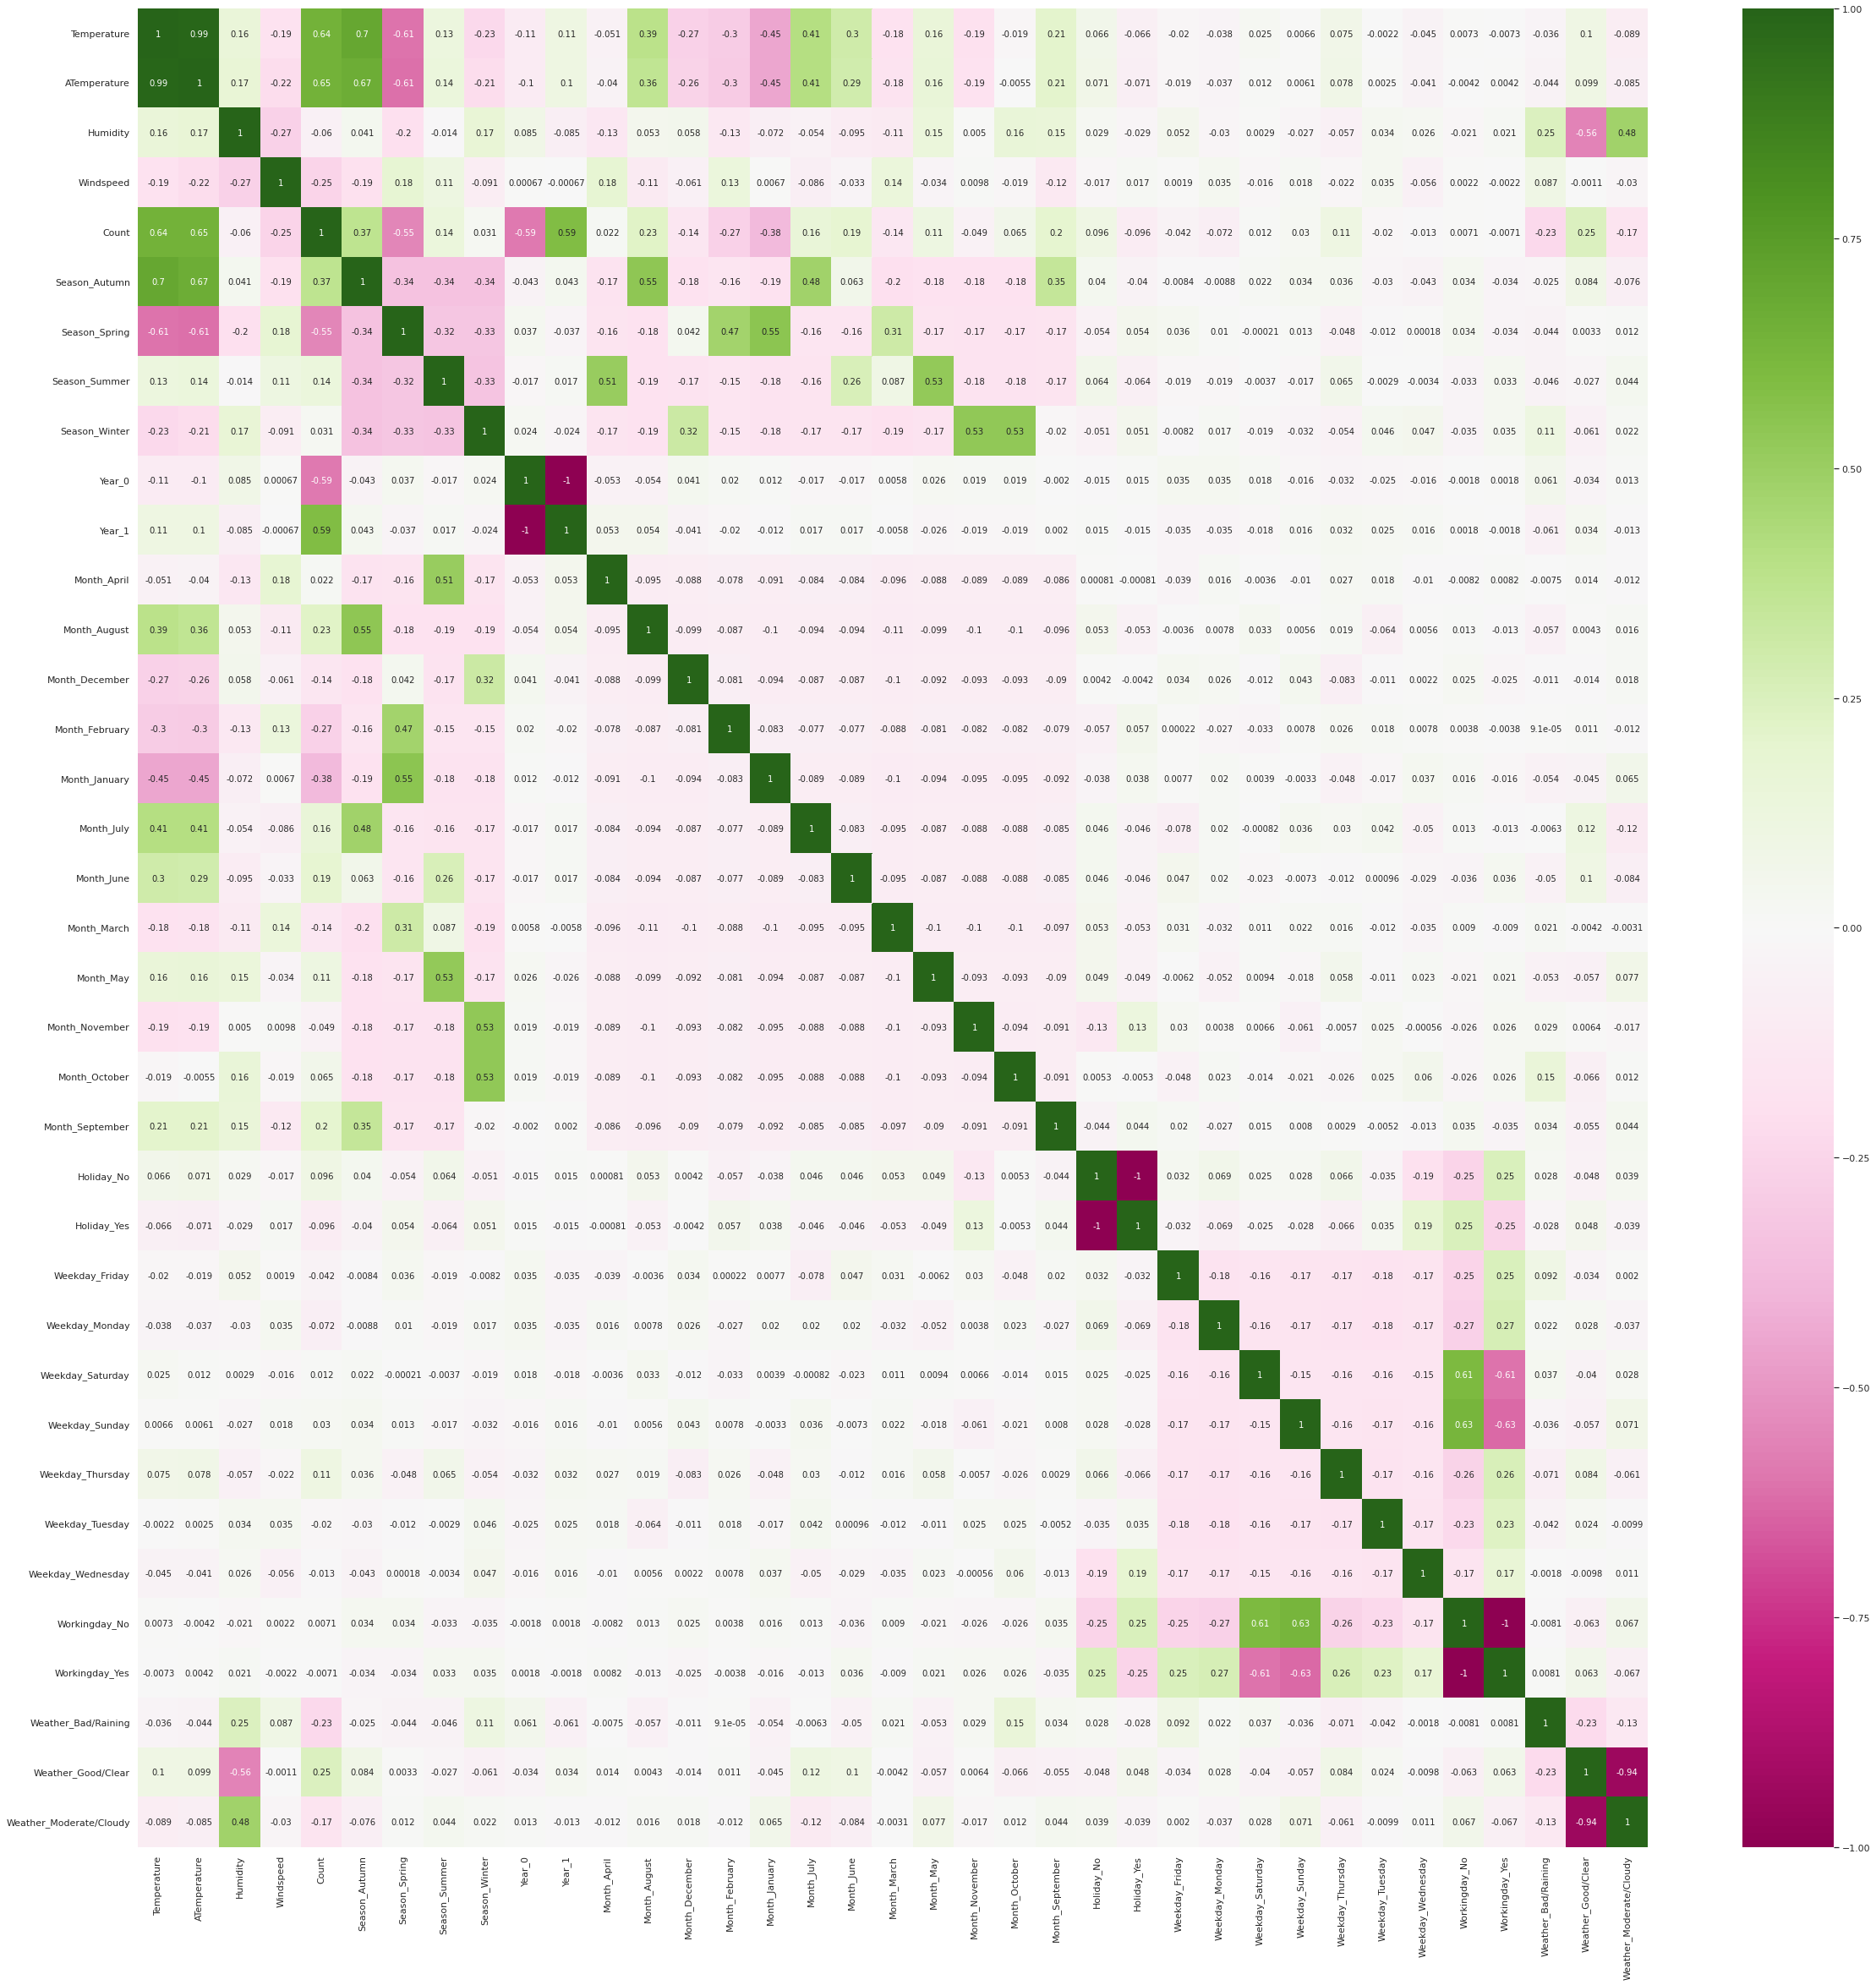

In [70]:
plt.figure(figsize=(40,40))
sns.heatmap(df_train.corr(), annot=True, cmap='PiYG', vmin=-1, vmax=1)
plt.show()

We can drop features with correlation~1
* Lets drop ATemperature since it is highly correlated(corr=1) with Temperature
* Lets drop Year_0 since it is highly correlated with Year_1
* Lets drop Holiday_No since it is highly correlated with Holiday_Yes
* Lets drop Workingday_No since it is highly correlated with Workingday_Yes
* Lets drop Weather_Moderate/Cloudy since it is highly correlated with Weather_Good/Clear

In [73]:
df_train = df_train.drop(['ATemperature','Year_0', 'Holiday_No', 'Workingday_No','Weather_Moderate/Cloudy'], axis = 1)
df_test = df_test.drop(['ATemperature','Year_0', 'Holiday_No', 'Workingday_No','Weather_Moderate/Cloudy'], axis = 1)

In [74]:
X_train = df_train.drop('Count', axis=1)
y_train = df_train['Count']
# X_train, y_train = X_train.values, y_train.values
y_train.shape, X_train.shape, type(X_train), type(y_train)

((511,), (511, 31), pandas.core.frame.DataFrame, pandas.core.series.Series)

In [75]:
X_test = df_test.drop('Count', axis=1)
y_test = df_test['Count']
# X_test, y_test = X_test.values, y_test.values
y_test.shape, X_test.shape, type(X_test), type(y_test)

((219,), (219, 31), pandas.core.frame.DataFrame, pandas.core.series.Series)

## Selecting Features with RFE

Using Linear Regression with RFE for feature selection

In [76]:
print('number of available features : ', X_train.shape[1])

number of available features :  31


In [77]:
lr = LinearRegression()
# lr.fit(X_train, y_train)

In [78]:
rfe = RFE(lr, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [79]:
print('Best 15 features selected by RFE')
rfe_cols = X_train.columns[rfe.support_]
print(*rfe_cols, sep='\n')

Best 15 features selected by RFE
Temperature
Humidity
Season_Spring
Season_Winter
Year_1
Month_December
Month_February
Month_January
Month_July
Month_May
Month_November
Month_September
Weekday_Monday
Weekday_Tuesday
Weather_Bad/Raining


In [80]:
sorted(list(zip(X_train.columns, rfe.support_, rfe.ranking_)), key=lambda x : x[2])

[('Temperature', True, 1),
 ('Humidity', True, 1),
 ('Season_Spring', True, 1),
 ('Season_Winter', True, 1),
 ('Year_1', True, 1),
 ('Month_December', True, 1),
 ('Month_February', True, 1),
 ('Month_January', True, 1),
 ('Month_July', True, 1),
 ('Month_May', True, 1),
 ('Month_November', True, 1),
 ('Month_September', True, 1),
 ('Weekday_Monday', True, 1),
 ('Weekday_Tuesday', True, 1),
 ('Weather_Bad/Raining', True, 1),
 ('Season_Autumn', False, 2),
 ('Month_April', False, 3),
 ('Month_August', False, 4),
 ('Month_June', False, 5),
 ('Weekday_Thursday', False, 6),
 ('Weekday_Sunday', False, 7),
 ('Weekday_Saturday', False, 8),
 ('Weekday_Friday', False, 9),
 ('Season_Summer', False, 10),
 ('Month_March', False, 11),
 ('Weekday_Wednesday', False, 12),
 ('Month_October', False, 13),
 ('Windspeed', False, 14),
 ('Holiday_Yes', False, 15),
 ('Weather_Good/Clear', False, 16),
 ('Workingday_Yes', False, 17)]

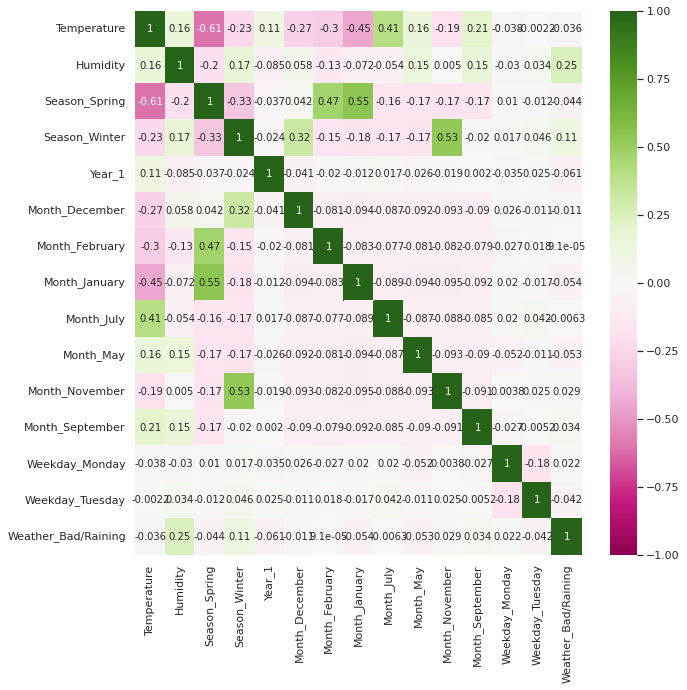

In [93]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train[rfe_cols].corr(), annot=True, cmap='PiYG', vmin=-1, vmax=1)
plt.show()

In [81]:
X_train[rfe_cols].head()

,Temperature,Humidity,Season_Spring,Season_Winter,Year_1,Month_December,Month_February,Month_January,Month_July,Month_May,Month_November,Month_September,Weekday_Monday,Weekday_Tuesday,Weather_Bad/Raining
653,0.509887,0.575354,0,1,1,0,0,0,0,0,0,0,0,0,0
576,0.815169,0.725633,0,0,1,0,0,0,1,0,0,0,0,0,0
426,0.442393,0.640189,1,0,1,0,0,0,0,0,0,0,0,0,0
728,0.245101,0.498067,1,0,1,1,0,0,0,0,0,0,1,0,0
482,0.395666,0.504508,0,0,1,0,0,0,0,0,0,0,0,0,0


## Model 1

In [104]:
X_train_lm1 = sm.add_constant(X_train[rfe_cols])

lm1 = sm.OLS(y_train, X_train_lm1).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     147.4
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          1.53e-171
Time:                        16:58:29   Log-Likelihood:                 472.24
No. Observations:                 511   AIC:                            -912.5
Df Residuals:                     495   BIC:                            -844.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3002    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


* Lets remove Month_February as it has p-value>.05 

##Model 2

In [105]:
model_cols = ['Temperature', 'Humidity', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_December', 'Month_January', 'Month_July',
              'Month_May', 'Month_November', 'Month_September', 'Weekday_Monday',
              'Weekday_Tuesday', 'Weather_Bad/Raining']
              
X_train_lm2 = sm.add_constant(X_train[model_cols])

lm2 = sm.OLS(y_train, X_train_lm2).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     157.2
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          4.68e-172
Time:                        16:58:46   Log-Likelihood:                 470.83
No. Observations:                 511   AIC:                            -911.7
Df Residuals:                     496   BIC:                            -848.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2925    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Lets remove Month_January and Month_December due to high p-value

##Model 3

In [106]:
model_cols = ['Temperature', 'Humidity', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_July',
              'Month_May', 'Month_November', 'Month_September', 'Weekday_Monday',
              'Weekday_Tuesday', 'Weather_Bad/Raining']

X_train_lm3 = sm.add_constant(X_train[model_cols])

lm3 = sm.OLS(y_train, X_train_lm3).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     182.2
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          2.00e-173
Time:                        16:59:00   Log-Likelihood:                 468.70
No. Observations:                 511   AIC:                            -911.4
Df Residuals:                     498   BIC:                            -856.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2812    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [107]:
# Lets check VIF since p-values are all low
get_vif(model_cols)

,Features,VIF
1,Humidity,16.22
0,Temperature,12.13
3,Season_Winter,2.66
2,Season_Spring,2.24
4,Year_1,2.05
7,Month_November,1.55
5,Month_July,1.43
6,Month_May,1.33
8,Month_September,1.24
10,Weekday_Tuesday,1.23


Lets remove Humidity due to high VIF

##Model 4

In [110]:
model_cols = ['Temperature', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_July',
              'Month_May', 'Month_November', 'Month_September', 'Weekday_Monday',
              'Weekday_Tuesday', 'Weather_Bad/Raining']

X_train_lm4 = sm.add_constant(X_train[model_cols])

lm4 = sm.OLS(y_train, X_train_lm4).fit()
print(lm4.summary())
get_vif(model_cols)

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     177.6
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          1.29e-164
Time:                        17:01:31   Log-Likelihood:                 445.09
No. Observations:                 511   AIC:                            -866.2
Df Residuals:                     499   BIC:                            -815.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1595    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
0,Temperature,3.38
3,Year_1,2.05
2,Season_Winter,1.94
6,Month_November,1.55
4,Month_July,1.39
1,Season_Spring,1.25
5,Month_May,1.25
7,Month_September,1.23
9,Weekday_Tuesday,1.22
8,Weekday_Monday,1.21


Lets remove Month_May due to high p-value

##Model 5

In [111]:
model_cols = ['Temperature', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_July',
              'Month_November', 'Month_September', 'Weekday_Monday',
              'Weekday_Tuesday', 'Weather_Bad/Raining']

X_train_lm5 = sm.add_constant(X_train[model_cols])

lm5 = sm.OLS(y_train, X_train_lm5).fit()
print(lm5.summary())
get_vif(model_cols)

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     195.2
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          1.60e-165
Time:                        17:02:27   Log-Likelihood:                 444.50
No. Observations:                 511   AIC:                            -867.0
Df Residuals:                     500   BIC:                            -820.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1642    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
0,Temperature,2.89
3,Year_1,2.05
2,Season_Winter,1.88
5,Month_November,1.55
4,Month_July,1.32
1,Season_Spring,1.22
8,Weekday_Tuesday,1.22
7,Weekday_Monday,1.21
6,Month_September,1.19
9,Weather_Bad/Raining,1.05


Lets remove Weekday_Monday due to high p-value


##Model 6

In [112]:
model_cols = ['Temperature', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_July',
              'Month_May', 'Month_November', 'Month_September',
              'Weekday_Tuesday', 'Weather_Bad/Raining']

X_train_lm6 = sm.add_constant(X_train[model_cols])

lm6 = sm.OLS(y_train, X_train_lm6).fit()
print(lm6.summary())
get_vif(model_cols)

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     194.2
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          4.26e-165
Time:                        17:03:43   Log-Likelihood:                 443.49
No. Observations:                 511   AIC:                            -865.0
Df Residuals:                     500   BIC:                            -818.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1535    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
0,Temperature,3.24
3,Year_1,2.05
2,Season_Winter,1.92
6,Month_November,1.55
4,Month_July,1.39
5,Month_May,1.25
7,Month_September,1.23
1,Season_Spring,1.22
8,Weekday_Tuesday,1.18
9,Weather_Bad/Raining,1.05


Lets remove Month_May due to high p-value

##Model 7

In [113]:
model_cols = ['Temperature', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_July',
              'Month_November', 'Month_September',
              'Weekday_Tuesday', 'Weather_Bad/Raining']

X_train_lm7 = sm.add_constant(X_train[model_cols])

lm7 = sm.OLS(y_train, X_train_lm7).fit()
print(lm7.summary())
get_vif(model_cols)

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     215.5
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          5.47e-166
Time:                        17:05:56   Log-Likelihood:                 442.81
No. Observations:                 511   AIC:                            -865.6
Df Residuals:                     501   BIC:                            -823.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1584    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
0,Temperature,2.76
3,Year_1,2.05
2,Season_Winter,1.87
5,Month_November,1.55
4,Month_July,1.32
1,Season_Spring,1.19
6,Month_September,1.19
7,Weekday_Tuesday,1.18
8,Weather_Bad/Raining,1.05


Lets remove Month_November due to high p-value

##Model 8

In [114]:
model_cols = ['Temperature', 'Season_Spring', 'Season_Winter', 'Year_1',
              'Month_July',
              'Month_September',
              'Weekday_Tuesday', 'Weather_Bad/Raining']

X_train_lm8 = sm.add_constant(X_train[model_cols])

lm8 = sm.OLS(y_train, X_train_lm8).fit()
print(lm8.summary())
get_vif(model_cols)

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     241.2
Date:                Sat, 13 Aug 2022   Prob (F-statistic):          1.39e-166
Time:                        17:07:36   Log-Likelihood:                 441.37
No. Observations:                 511   AIC:                            -864.7
Df Residuals:                     502   BIC:                            -826.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1534    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
0,Temperature,2.76
3,Year_1,2.05
4,Month_July,1.32
2,Season_Winter,1.31
1,Season_Spring,1.19
5,Month_September,1.18
6,Weekday_Tuesday,1.18
7,Weather_Bad/Raining,1.05


We have a good model now with p-value < 0.05 and low VIF

# Conclusion

Most Significant Features as per the best model are : 

1. 'Temperature'
2. 'Season_Spring'
3. 'Season_Winter'
4. 'Year_1'
5. 'Month_July'
6. 'Month_September'
7. 'Weekday_Tuesday'
8. 'Weather_Bad/Raining'

